# Amazon Reviews Sentiment — Comparison of 4 NLP Approaches
This Colab notebook compares 4 solutions on the **same Amazon reviews dataset**:

1. **Word2Vec** (train embeddings) → classic ML classifier  
2. **GloVe** (pretrained embeddings) → classic ML classifier  
3. **BERT embeddings + classic ML** (feature extraction)  
4. **BERT fine-tuning** (end-to-end training)

> Output: metrics table + confusion matrices + a short discussion.


In [ ]:

!pip -q install "gensim==4.3.2" "transformers==4.41.2" "safetensors<0.5"

import os, re, string, random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 99.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 127.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.8/434.8 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 117.2 MB/s eta 0:00:00


In [ ]:
# (Optional) Use GPU for BERT steps
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


## 1) Load Amazon dataset
Upload your dataset file (CSV).  
The notebook will try to **auto-detect** the text + label columns (you can override).

In [ ]:
from google.colab import files
uploaded = files.upload()

data_path = next(iter(uploaded.keys()))
print("Loaded:", data_path)

df = pd.read_csv(data_path)
print("Shape:", df.shape)
df.head()


Saving Amazon_Unlocked_Mobile.csv to Amazon_Unlocked_Mobile.csv
Loaded: Amazon_Unlocked_Mobile.csv
Shape: (413840, 6)


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [ ]:
df.columns


Index(['Product Name', 'Brand Name', 'Price', 'Rating', 'Reviews',
       'Review Votes'],
      dtype='object')

In [ ]:

def pick_first_existing(cols, candidates):
    lower_map = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    return None

TEXT_COL = "Reviews"
LABEL_COL = "Rating"

print("Auto-detected TEXT_COL =", TEXT_COL)
print("Auto-detected LABEL_COL =", LABEL_COL)

TEXT_COL = "Reviews"


assert TEXT_COL is not None and LABEL_COL is not None, "Set TEXT_COL and LABEL_COL manually."

df = df[[TEXT_COL, LABEL_COL]].dropna()
df.rename(columns={TEXT_COL:"text", LABEL_COL:"label_raw"}, inplace=True)
df.head()

Auto-detected TEXT_COL = Reviews
Auto-detected LABEL_COL = Rating


,text,label_raw
0,I feel so LUCKY to have found this used (phone...,5
1,"nice phone, nice up grade from my pantach revu...",4
2,Very pleased,5
3,It works good but it goes slow sometimes but i...,4
4,Great phone to replace my lost phone. The only...,4


In [ ]:

def normalize_label(series: pd.Series):
    s = series.copy()

    # numeric
    if pd.api.types.is_numeric_dtype(s):

        uniq = sorted(s.dropna().unique().tolist())
        if set(uniq).issubset({0,1}):
            return s.astype(int), df.index


        keep = (s <= 2) | (s >= 4)
        s2 = s[keep]
        y = (s2 >= 4).astype(int)
        return y, s2.index

    # string labels
    s_str = s.astype(str).str.lower().str.strip()
    pos = {"positive","pos","1","true","yes"}
    neg = {"negative","neg","0","false","no"}

    keep = s_str.isin(pos | neg)
    y = s_str[keep].map(lambda v: 1 if v in pos else 0).astype(int)
    return y, s_str[keep].index

y, idx = normalize_label(df["label_raw"])
df2 = df.loc[idx].copy()
df2["label"] = y.values

print("After label normalization:", df2.shape)
print(df2["label"].value_counts())

df2.head()


After label normalization: (382007, 3)
label
1    284948
0     97059
Name: count, dtype: int64


,text,label_raw,label
0,I feel so LUCKY to have found this used (phone...,5,1
1,"nice phone, nice up grade from my pantach revu...",4,1
2,Very pleased,5,1
3,It works good but it goes slow sometimes but i...,4,1
4,Great phone to replace my lost phone. The only...,4,1


In [ ]:
df = df2.copy()
TEXT_COL = "text"
LABEL_COL = "label"

print(df.shape)
print(df[LABEL_COL].value_counts())
df.head()


(382007, 3)
label
1    284948
0     97059
Name: count, dtype: int64


,text,label_raw,label
0,I feel so LUCKY to have found this used (phone...,5,1
1,"nice phone, nice up grade from my pantach revu...",4,1
2,Very pleased,5,1
3,It works good but it goes slow sometimes but i...,4,1
4,Great phone to replace my lost phone. The only...,4,1


In [ ]:
# Train/Val/Test split
train_df, temp_df = train_test_split(df2, test_size=0.30, random_state=42, stratify=df2["label"])
val_df, test_df  = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df["label"])

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)


Train: (267404, 3) Val: (57301, 3) Test: (57302, 3)


In [ ]:
import nltk

nltk.download("punkt")
nltk.download("punkt_tab")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# =========================
# 1.3) Basic text cleaning/tokenization for word embedding methods
# =========================
import nltk
nltk.download("punkt", quiet=True)

from nltk.tokenize import word_tokenize

def simple_clean(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-z\s']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    return [t for t in word_tokenize(simple_clean(text)) if len(t) > 1]

train_tokens = train_df["text"].map(tokenize).tolist()
val_tokens   = val_df["text"].map(tokenize).tolist()
test_tokens  = test_df["text"].map(tokenize).tolist()

print("Example tokens:", train_tokens[0][:20])


Example tokens: ['great', 'phone', 'big', 'screen', 'and', 'plenty', 'of', 'features', 'that', 'make', 'galaxy', "'s", 'the', 'only', 'way', 'to', 'go', 'with', 'phone', "'ve"]


## 2) Shared evaluation helpers

In [ ]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0,1], ["neg","pos"])
    plt.yticks([0,1], ["neg","pos"])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.show()

def evaluate_binary(y_true, y_pred):
    return {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred))
    }


## 3) Approach A — Word2Vec

Word2Vec VAL: {'accuracy': 0.9263712675171463, 'f1': 0.951023298468825}
Word2Vec TEST: {'accuracy': 0.9262678440543087, 'f1': 0.9509718595880475}


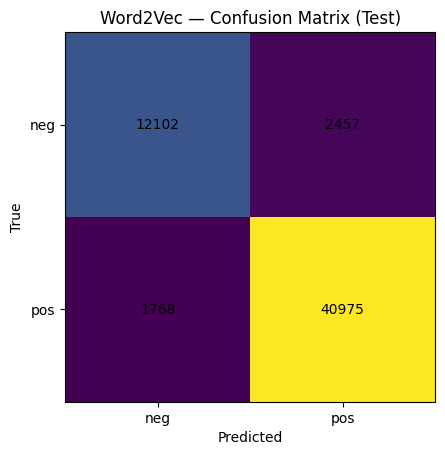

In [ ]:
from gensim.models import Word2Vec

# Train Word2Vec on training tokens
w2v = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=10
)

def doc_vector_from_w2v(tokens, model):
    vecs = []
    for t in tokens:
        if t in model.wv:
            vecs.append(model.wv[t])
    if len(vecs) == 0:
        return np.zeros(model.vector_size, dtype=np.float32)
    return np.mean(vecs, axis=0)

X_train_w2v = np.vstack([doc_vector_from_w2v(t, w2v) for t in train_tokens])
X_val_w2v   = np.vstack([doc_vector_from_w2v(t, w2v) for t in val_tokens])
X_test_w2v  = np.vstack([doc_vector_from_w2v(t, w2v) for t in test_tokens])

clf_w2v = LogisticRegression(max_iter=2000)
clf_w2v.fit(X_train_w2v, train_df["label"])

val_pred = clf_w2v.predict(X_val_w2v)
test_pred = clf_w2v.predict(X_test_w2v)

w2v_val = evaluate_binary(val_df["label"], val_pred)
w2v_test = evaluate_binary(test_df["label"], test_pred)

print("Word2Vec VAL:", w2v_val)
print("Word2Vec TEST:", w2v_test)
plot_confusion(test_df["label"], test_pred, "Word2Vec — Confusion Matrix (Test)")


## 4) Approach B — GloVe

[==================================================] 100.0% 128.1/128.1MB downloaded
GloVe VAL: {'accuracy': 0.8769131428770877, 'f1': 0.9190807815422035}
GloVe TEST: {'accuracy': 0.8794980977976335, 'f1': 0.9208242079554184}


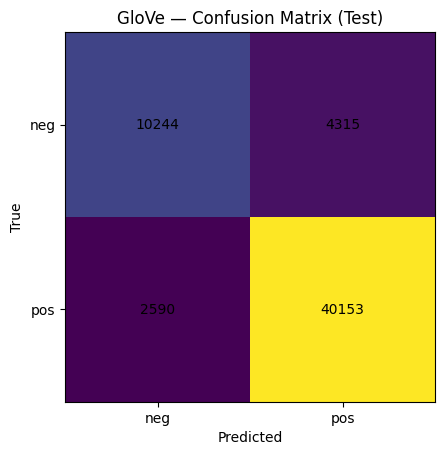

In [ ]:
import gensim.downloader as api


glove = api.load("glove-wiki-gigaword-100")  # 100-d

def doc_vector_from_glove(tokens, kv):
    vecs = []
    for t in tokens:
        if t in kv:
            vecs.append(kv[t])
    if len(vecs) == 0:
        return np.zeros(kv.vector_size, dtype=np.float32)
    return np.mean(vecs, axis=0)

X_train_glove = np.vstack([doc_vector_from_glove(t, glove) for t in train_tokens])
X_val_glove   = np.vstack([doc_vector_from_glove(t, glove) for t in val_tokens])
X_test_glove  = np.vstack([doc_vector_from_glove(t, glove) for t in test_tokens])

clf_glove = LogisticRegression(max_iter=2000)
clf_glove.fit(X_train_glove, train_df["label"])

val_pred = clf_glove.predict(X_val_glove)
test_pred = clf_glove.predict(X_test_glove)

glove_val = evaluate_binary(val_df["label"], val_pred)
glove_test = evaluate_binary(test_df["label"], test_pred)

print("GloVe VAL:", glove_val)
print("GloVe TEST:", glove_test)
plot_confusion(test_df["label"], test_pred, "GloVe — Confusion Matrix (Test)")


## 5) Approach C — BERT embeddings


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT-Embeddings VAL: {'accuracy': 0.9359348004397829, 'f1': 0.9572448492330627}
BERT-Embeddings TEST: {'accuracy': 0.9375763498656242, 'f1': 0.958360980152494}


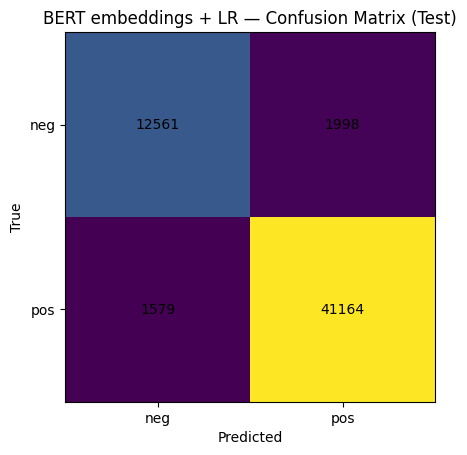

In [ ]:
from transformers import AutoTokenizer, AutoModel

bert_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_name)
bert = AutoModel.from_pretrained(bert_name).to(device)
bert.eval()

@torch.no_grad()
def bert_embed_texts(texts, batch_size=32, max_len=192, pooling="cls"):
    all_vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
        enc = {k:v.to(device) for k,v in enc.items()}
        out = bert(**enc)
        last_hidden = out.last_hidden_state  # (B, T, H)
        if pooling == "cls":
            vec = last_hidden[:, 0, :]        # (B, H)
        else:
            # mean pooling with attention mask
            mask = enc["attention_mask"].unsqueeze(-1)  # (B, T, 1)
            summed = (last_hidden * mask).sum(dim=1)
            counts = mask.sum(dim=1).clamp(min=1)
            vec = summed / counts
        all_vecs.append(vec.detach().cpu().numpy())
    return np.vstack(all_vecs)

X_train_bert = bert_embed_texts(train_df["text"].tolist(), pooling="cls")
X_val_bert   = bert_embed_texts(val_df["text"].tolist(), pooling="cls")
X_test_bert  = bert_embed_texts(test_df["text"].tolist(), pooling="cls")

clf_bertfe = LogisticRegression(max_iter=2000)
clf_bertfe.fit(X_train_bert, train_df["label"])

val_pred = clf_bertfe.predict(X_val_bert)
test_pred = clf_bertfe.predict(X_test_bert)

bertfe_val = evaluate_binary(val_df["label"], val_pred)
bertfe_test = evaluate_binary(test_df["label"], test_pred)

print("BERT-Embeddings VAL:", bertfe_val)
print("BERT-Embeddings TEST:", bertfe_test)
plot_confusion(test_df["label"], test_pred, "BERT embeddings + LR — Confusion Matrix (Test)")


## 6) Approach D — BERT fine-tuning




In [ ]:
X_train = train_df["text"].values
y_train = train_df["label"].values

X_val = val_df["text"].values
y_val = val_df["label"].values

X_test = test_df["text"].values
y_test = test_df["label"].values


In [ ]:
import numpy as np
import tensorflow as tf
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

MODEL_NAME = "distilbert-base-uncased"
NUM_LABELS = 2
BATCH = 16
MAX_LEN = 256

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_hf = Dataset.from_dict({"text": list(X_train), "label": y_train.tolist()})
val_hf   = Dataset.from_dict({"text": list(X_val),   "label": y_val.tolist()})
test_hf  = Dataset.from_dict({"text": list(X_test),  "label": y_test.tolist()})

def tok(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LEN)

train_tok = train_hf.map(tok, batched=True, remove_columns=["text"])
val_tok   = val_hf.map(tok,   batched=True, remove_columns=["text"])
test_tok  = test_hf.map(tok,  batched=True, remove_columns=["text"])

collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

train_ds = train_tok.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=True,
    batch_size=BATCH,
    collate_fn=collator
)

val_ds = val_tok.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=False,
    batch_size=BATCH,
    collate_fn=collator
)

test_ds = test_tok.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=False,
    batch_size=BATCH,
    collate_fn=collator
)

model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS, from_pt=True
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

model.fit(train_ds, validation_data=val_ds, epochs=2)

logits = model.predict(test_ds).logits
y_pred = np.argmax(logits, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/267404 [00:00<?, ? examples/s]

Map:   0%|          | 0/57301 [00:00<?, ? examples/s]

Map:   0%|          | 0/57302 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

Epoch 1/2
16713/16713 [==============================] - 2108s 124ms/step - loss: 0.0970 - accuracy: 0.9659 - val_loss: 0.0714 - val_accuracy: 0.9767
Epoch 2/2
3582/3582 [==============================] - 123s 34ms/step
Accuracy: 0.9830372412830267
F1: 0.9886075949367089
[[14156   403]
 [  569 42174]]
